# Demo of Detailed Voxels for Vegetation Modelling

Notebook creator: Hannah Weiser, 2026

This demo demonstrates the different `detailedVoxel` options for modelling vegetation using a single tree scene. We perform both virtual UAV-borne laser scanning (ULS) and airborne laser scanning (ALS).

In [1]:
import helios
import numpy as np
import matplotlib.pyplot as plt

## Creating the virtual scene

Our virtual scene consists of a ground plane and five versions of the same tree object. The stem of the tree is always loaded as 3D polygon mesh models (OBJ). The tree crown is loaded using `detailedVoxels` with different modes and parameters, from left to right:
- Fixed voxel size (25 cm)
- Fixed voxel size (5 cm)
- Transmittive voxels (25 cm)
- Scaled voxels by plant area density (25 cm)
- Scaled voxels by plant area density (25 cm) with a random shift of scaled voxels within their voxel space.
We use the VOX format by [AMAPVox](https://amapvox.org/index.html), a software for voxel-based computation of plant area density (PAD).

For reference, see [Weiser et al. 2021](https://doi.org/10.1016/j.rse.2021.112641) and the [Scene page](https://github.com/3dgeo-heidelberg/helios/wiki/Scene#b-voxels) in the Wiki.

The scene parts are furthermore geometrically transformed to position them in the scene.

In [2]:
# load objs and create transformations
groundplane = helios.ScenePart.from_obj("../data/sceneparts/basic/groundplane/groundplane.obj").scale(15)  # scale groundplane by 15
tree_positions = [[float(x), 15.0, -241.401] for x in range(-22, 3, 5)]  # trees positioned 5 m apart along the x-axis

stem1 = helios.ScenePart.from_obj("../data/sceneparts/syssifoss/F_BR08_08_stem_Poisson.obj")
crown1 = helios.ScenePart.from_vox("../data/sceneparts/syssifoss/F_BR08_08_crown_250.vox",
                                  intersection_mode="fixed")

stem2 = helios.ScenePart.from_obj("../data/sceneparts/syssifoss/F_BR08_08_stem_Poisson.obj")
crown2 = helios.ScenePart.from_vox("../data/sceneparts/syssifoss/F_BR08_08_crown_50.vox",
                                  intersection_mode="fixed")

stem3 = helios.ScenePart.from_obj("../data/sceneparts/syssifoss/F_BR08_08_stem_Poisson.obj")
crown3 = helios.ScenePart.from_vox("../data/sceneparts/syssifoss/F_BR08_08_merged.vox",
                                  intersection_mode="scaled")  # should be "transmittive" but this raises an error

stem4 = helios.ScenePart.from_obj("../data/sceneparts/syssifoss/F_BR08_08_stem_Poisson.obj")
crown4 = helios.ScenePart.from_vox("../data/sceneparts/syssifoss/F_BR08_08_merged.vox",
                                  intersection_mode="scaled",
                                  intersection_argument=0.5)

stem5 = helios.ScenePart.from_obj("../data/sceneparts/syssifoss/F_BR08_08_stem_Poisson.obj")
crown5 = helios.ScenePart.from_vox("../data/sceneparts/syssifoss/F_BR08_08_merged.vox",
                                  intersection_mode="scaled",
                                  intersection_argument=0.5,
                                  random_shift=True)

# Position the trees
for i, (stem, crown) in enumerate(zip([stem1, stem2, stem3, stem4, stem5], [crown1, crown2, crown3, crown4, crown5])):
    stem.translate(tree_positions[i])
    crown.translate(tree_positions[i])

#create scene
scene = helios.StaticScene(scene_parts=[groundplane, stem1, crown1, stem2, crown2, stem3, crown3, stem4, crown4, stem5, crown5])

## Platform and scanner

In [3]:
# scanner and platform for ALS and ULS surveys respectively
scanner_als = helios.scanner_from_name("riegl_lms_q780")
platform_als = helios.platform_from_name("sr22")
scanner_uls = helios.scanner_from_name("riegl_vux_1uav")
platform_uls = helios.platform_from_name("copter_linearpath")

## Scanner, platform and full waveform settings

In [4]:
scanner_settings_als = helios.ScannerSettings(
    pulse_frequency=100_000 * helios.units.Hz,
    scan_frequency=200 * helios.units.Hz,
    scan_angle=30 * helios.units.deg,
    trajectory_time_interval=0.05 * helios.units.s
)

scanner_settings_uls = helios.ScannerSettings(
    pulse_frequency=100_000 * helios.units.Hz,
    scan_frequency=50 * helios.units.Hz,
    scan_angle=90 * helios.units.deg,
    trajectory_time_interval=0.01 * helios.units.s
)

fullwave_settings = helios.FullWaveformSettings(
    beam_sample_quality=3,
    bin_size = 0.25 * helios.units.ns,
    win_size = 1 * helios.units.ns,
    max_fullwave_range = 100 * helios.units.ns
)

platform_settings_uls = helios.DynamicPlatformSettings(z=50, speed_m_s=5)
platform_settings_als = helios.DynamicPlatformSettings(z=50, speed_m_s=5)

## Survey Route

In [5]:
survey_uls = helios.Survey(scanner=scanner_uls, platform=platform_uls, scene=scene, full_waveform_settings=fullwave_settings)
survey_als = helios.Survey(scanner=scanner_als, platform=platform_als, scene=scene, full_waveform_settings=fullwave_settings)

In [6]:
# Would be nice if the following would work, but it doesn't (first leg will just have the values from the last waypoint)
waypoints_uls = [
    [-30, -30, True],
    [-30, 30, False],
    [0, 30, True],
    [0, -30, False],
    [30, -30, True],
    [30, 30, True],
    [-30, 30, False],
    [-30, 0, True],
    [30, 0, False],
    [30, -30, True],
    [-30, -30, False]
]
for x, y, active in waypoints_uls:
    platform_settings_uls.x = x
    platform_settings_uls.y = y
    scanner_settings_uls.is_active = active
    leg = helios.Leg(scanner_settings=scanner_settings_uls,
                     platform_settings=platform_settings_uls)
    survey_uls.add_leg(leg)

## Executing the survey

In [7]:
# points_uls, trajectory_uls = survey_uls.run(verbosity=helios.LogVerbosity.VERBOSE, format=helios.OutputFormat.NPY)

output = survey_uls.run(verbosity=helios.LogVerbosity.VERBOSE, format=helios.OutputFormat.LAZ)

KeyboardInterrupt: 

In [10]:
points_als, trajectory_als = survey_als.run(verbosity=LogVerbosity.VERBOSE, format=OutputFormat.NPY)

## Visualizing the results

Now we can display the resulting point clouds.

### 1) ULS point cloud

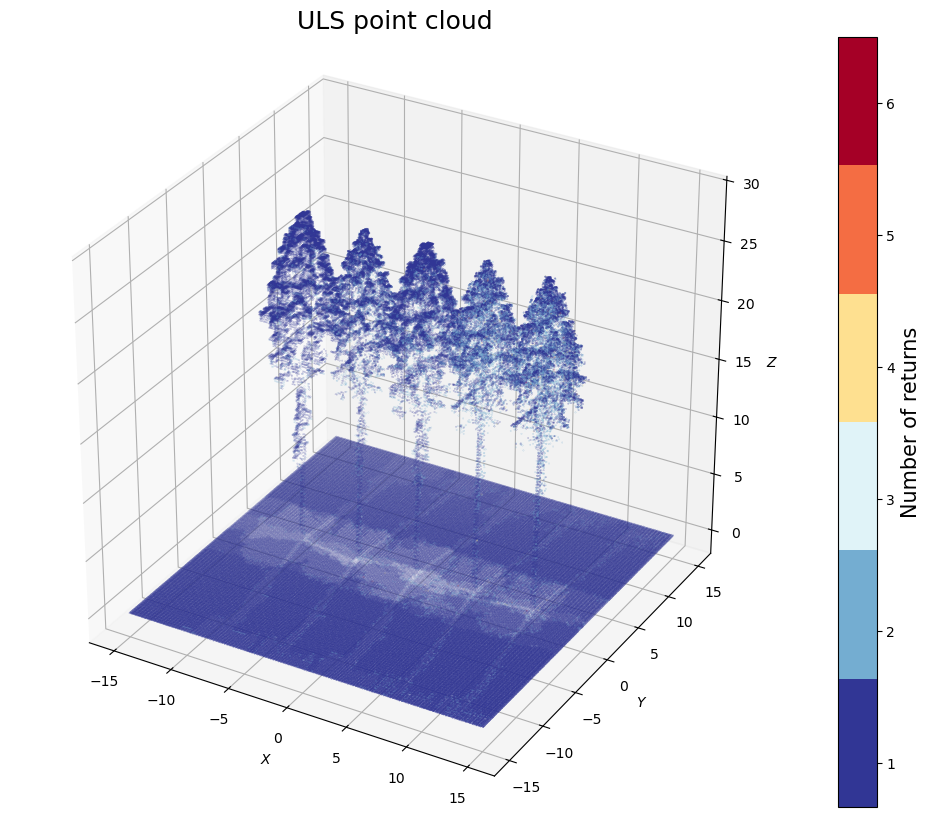

In [13]:
coords = points_uls["position"]
nor = points_uls["number_of_returns"]

# Matplotlib figure
fig = plt.figure(figsize=(15, 10))


# settings for a discrete colorbar
N = int(np.max(nor))
cmap = plt.get_cmap("RdYlBu_r", N)
# Scatter plot (coloured by number of returns).
ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    coords[:, 0],
    coords[:, 1],
    coords[:, 2],
    c=nor,
    cmap=cmap,
    s=0.02
)

# Add axis labels.
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")

# set equal axes
box = (np.ptp(coords[:, 0]), np.ptp(coords[:, 1]), np.ptp(coords[:, 2]))
ax.set_box_aspect(box)

# Set title.
ax.set_title(label="ULS point cloud", fontsize=18)

tick_locs = (np.arange(1, N + 1) + 0.5) * (N) / (N + 1)
cbar = plt.colorbar(sc, ticks=tick_locs)

cbar.set_label("Number of returns", fontsize=15)
tick_labels = [str(i) for i in range(1, N + 1)]
cbar.ax.set_yticklabels(tick_labels)

# Display results
plt.show()

On the tree on the very left, we clearly see the outlines of the fairly large (25 cm) opaque voxels. Due to the large voxel size, the beams can barely penetrate into the canopy and generate mostly single returns at the surface of the outer voxels.

The second tree from the left already looks more realistic due to the finer voxel grid. Still, there are relatively little multiple returns.

The tree in the middle is using the "transmittive" mode, where we assume that each voxel is filled with randomly distributed infinitely small sized leaf scatterers ("turbid medium"). Each voxel has a leaf area density and a leaf angle distribution is defined for the entire crown. From this, the extinction coefficient $\sigma$ is calculated. Based on $\sigma$, HELIOS++ determines where and if a return is generated within the voxel using a stochastic model ([Scene#b-voxels](https://github.com/3dgeo-heidelberg/helios/wiki/Scene#b-voxels).

The two trees on the right use opaque voxels again, but voxels are scaled, so that the voxel leaf area density is proportional to the scaled voxel cube area. This means that smaller voxel cubes are generated where leaf area density is low. While generated using a voxel grid of 25 cm (like for the first tree), the scaling results in a voxel model which the laser beam can penetrate into and hence more realistic point clouds and number of multiple returns.

For the scaled and the transmittive mode, it is necessary to first compute voxel-based leaf area density. HELIOS++ supports the output format of AMAPVox ([Vincent et al. 2017](https://doi.org/10.1016/j.rse.2017.05.034)), a LiDAR Voxelisation Software for the computation of transmittance and estimation of leaf area density. The Python script scripts/utils/voxelizer_write_vox.py can be used to generate a simple .vox file which can be used for the "fixed" mode. It voxelizes a point cloud with a given resolution and writes it into the HELIOS++-readable voxel file format.

### 2) ALS point cloud

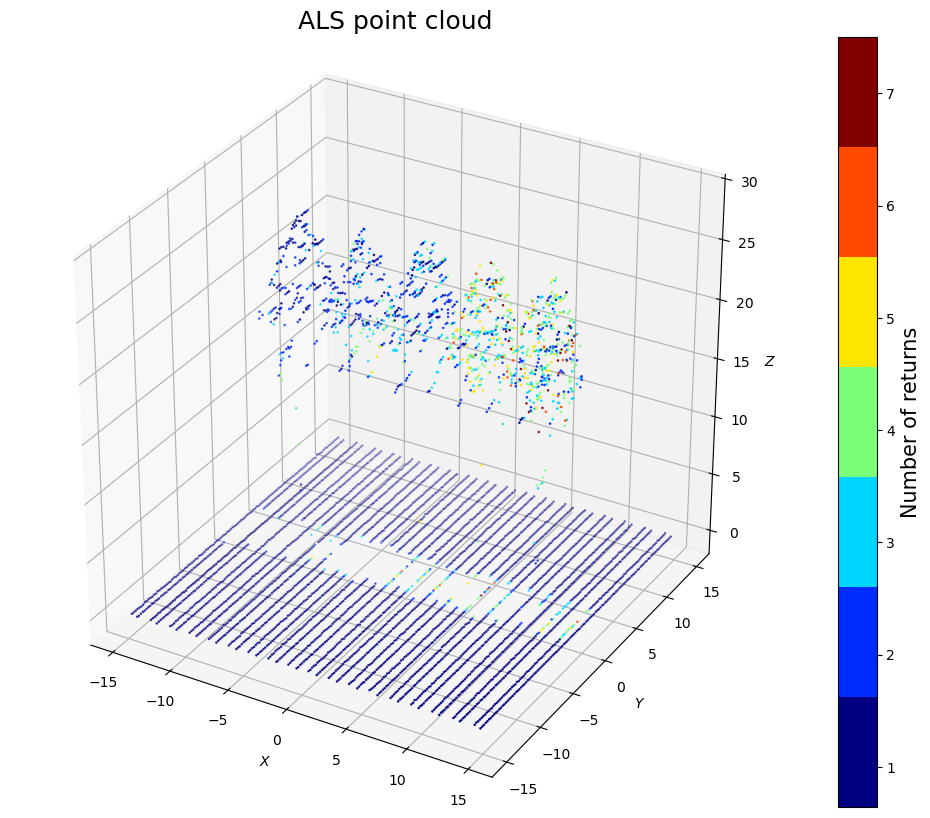

In [14]:
coords = points_als["position"]
nor = points_als["number_of_returns"]

# Matplotlib figure
fig = plt.figure(figsize=(15, 10))

# settings for a discrete colorbar
N = int(np.max(nor))
cmap = plt.get_cmap("jet", N)
# Scatter plot (coloured by number of returns).
ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    coords[:, 0],
    coords[:, 1],
    coords[:, 2],
    c=nor,
    cmap=cmap,
    s=0.7,
    label="scene",
)

# Add axis labels.
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")

# set equal axes
box = (np.ptp(coords[:, 0]), np.ptp(coords[:, 1]), np.ptp(coords[:, 2]))
ax.set_box_aspect(box)

# Set title.
ax.set_title(label="ALS point cloud", fontsize=18)

tick_locs = (np.arange(1, N + 1) + 0.5) * (N) / (N + 1)
cbar = plt.colorbar(sc, ticks=tick_locs)

cbar.set_label("Number of returns", fontsize=15)
tick_labels = [str(i) for i in range(1, N + 1)]
cbar.ax.set_yticklabels(tick_labels)

# Display results
plt.show()